# Ballistics

In [20]:
from math import pi, atan
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import fsolve
import pandas as pd
from scipy.integrate import solve_ivp

In [21]:
mrad_per_click = 0.10
v0 = 950 # m/s
bc = 0.275
bullet_weight = 55 * 0.00006479891  # kg
bullet_diameter = 0.224 * 0.0254   # m
bullet_area = pi * (bullet_diameter / 2) ** 2  # m2
h = 70 / 1000 # m
d_zero = 100 # m
d_min = 0 # m
d_max = 325 # m
g = 9.82
air_density = 1.225  # Air density (kg/m³) at sea level

In [22]:
# Correct drag coefficient calculation to handle unit consistency
# Convert BC from imperial to metric:
def convert_bc_to_metric(bc):
    inch_to_meter = 0.0254  # Conversion factor from inches to meters
    bc_metric = bc / inch_to_meter**2  # Adjust BC for metric units
    return bc_metric


In [23]:
def velocityT(t, bc):
    return v0 * np.exp(-t / bc)

In [24]:
def drag_coefficient(bc, m, A): # G1 model for bc
    return m / (bc * A)

In [25]:
def dragF(dragC, v, A):
    return 0.5 * dragC * air_density * v**2 * A

In [26]:
def velocityD(v0, dragC, A, d, m):
    return v0 * np.exp(- (dragC * air_density * A * d) / (2 * m))

In [27]:
def calculate_barrel_angle(hob, poi, d0):
    # hob: height over bore in meters
    # poi: point of impact in meters (negative if below the target)
    # distance: distance to the target in meters
    return atan((hob + poi) / d0)  # Angle in radians


In [28]:
# Function to calculate time of flight considering initial velocity and drag
def time_of_flight(v0, bc, d):
    bc_metric = convert_bc_to_metric(bc)  # Convert BC to metric units
    drag = drag_coefficient(bc_metric, bullet_weight, bullet_area)  # Calculate drag coefficient
    
    # Define a small-time step for integration
    dt = 0.001  # time step in seconds
    time = 0.0  # initialize time
    distance_travelled = 0.0  # initialize distance
    # Iterate until the bullet reaches the target distance
    while distance_travelled < d:
        velocity = velocityD(v0, drag, bullet_area, distance_travelled, bullet_weight)
        distance_travelled += velocity * dt
        time += dt
    return time


In [29]:
bc_metric = convert_bc_to_metric(bc)
drag_coefficient_g1 = drag_coefficient(bc_metric, bullet_weight, bullet_area)


In [30]:
def calculate_velocities(v0, c_drag, bullet_area, bullet_weight, distances):
    velocities = []
    for d in distances:
        velocities.append(velocityD(v0, c_drag, bullet_area, d, bullet_weight))
    return velocities    
    

In [31]:
def calculate_poi(d_target, c_drag, hob, v0, angle_rad):
    t_total = d_target / (v0 * np.cos(angle_rad))  # Time to reach target distance
    t_steps = np.linspace(0, t_total, 1000)  # Time steps for numerical integration
    x = v0 * np.cos(angle_rad) * t_steps  # Horizontal distance over time
    y = hob + v0 * np.sin(angle_rad) * t_steps - 0.5 * g * t_steps ** 2  # Vertical position without drag
    
    # Update velocity and position with drag
    for i in range(1, len(t_steps)):
        v_x = v0 * np.cos(angle_rad) * np.exp(- (c_drag * air_density * bullet_area * x[i]) / (2 * bullet_weight))
        v_y = v0 * np.sin(angle_rad) * np.exp(- (c_drag * air_density * bullet_area * x[i]) / (2 * bullet_weight))
        y[i] = hob + v_y * t_steps[i] - 0.5 * g * t_steps[i]**2  # Update y position with drag
        
    return y[-1]  # Return the final vertical position at distance


def calculate_pois(d0, d_max, step, c_drag, hob, v0, angle):
    pois = []
    for i in range(d0, d_max + step, step):
        pois.append(calculate_poi(i, c_drag, hob, v0, angle))
    return pois

In [32]:
# Define the bullet trajectory with drag affecting both x and y velocities
def bullet_trajectory(t, y, c_drag, bullet_weight):
    x, y_pos, v_x, v_y = y
    speed = np.sqrt(v_x**2 + v_y**2)  # Total speed
    drag_x = -0.5 * c_drag * air_density * bullet_area * speed * v_x / bullet_weight  # Drag force on x
    drag_y = -0.5 * c_drag * air_density * bullet_area * speed * v_y / bullet_weight  # Drag force on y

    return [v_x, v_y, drag_x, drag_y - g]  # Ret

def calculate_poi_with_integration(d_target, c_drag, hob, v0, angle_rad):
    if d_target == 0:
        # For zero distance, return the initial height above ground level
        return np.nan
    v_x0 = v0 * np.cos(angle_rad)  # Initial velocity component in the x direction
    v_y0 = v0 * np.sin(angle_rad)  # Initial velocity component in the y direction
    y0 = [0, hob, v_x0, v_y0]  # Initial conditions: [x0, y0, vx0, vy0]
    t_max = d_target / v_x0
    # Ensure t_eval is a 1-dimensional array
    t_eval = np.linspace(0, t_max, 1000)

    # Use adaptive integration (Runge-Kutta method)
    #sol = solve_ivp(bullet_trajectory, [0, t_max], y0, args=(c_drag, bullet_weight), t_eval=t_eval)
    
    sol = solve_ivp(
        bullet_trajectory, 
        [0, t_max], 
        y0, 
        args=(c_drag, bullet_weight), 
        t_eval=t_eval, 
        method='LSODA',  # More stable for complex problems
        rtol=1e-8,       # Relative tolerance for precision
        atol=1e-10
    )

    x = sol.y[0]  # Horizontal positions
    y = sol.y[1]  # Vertical positions

    return y[-1] - h  # Difference between final y position and initial height

def calculate_pois_with_integration(d0, d_max, step, c_drag, hob, v0, angle_rad):
    pois = []
    for d in range(d0, d_max + step, step):
        poi = calculate_poi_with_integration(d, c_drag, hob, v0, angle_rad)
        if np.isinf(poi):
            print(f"Warning: Integration failed for distance {d}. POI set to NaN.")
            pois.append(np.nan)
        else:
            pois.append(poi)
    return np.array(pois)

In [33]:
def poi_to_mrad(poi, d):
    if d == 0:
        return 0
    return -(poi / d * 1000.0)

def calculate_mrads(distances, pois):
    mrads = []
    for i in range(len(distances)):
        mrads.append(poi_to_mrad(pois[i], distances[i]))
    return mrads
        

In [34]:
# Target distance
d_target = d_zero  # Target distance in meters

# Initial guess for the angle
angle_guess = 0.
# Function to find the angle that makes y(d_target) = 0 (hit the target at height zero)
def find_angle(a):
    # a is passed as an array, so we extract the scalar value using a[0]
    a = a[0]
    return calculate_poi_with_integration(d_zero, drag_coefficient_g1, h, v0, a)

# Use fsolve to find the correct angle
result = fsolve(find_angle, angle_guess)

optimal_angle = result[0]


In [35]:
step = 25 # m
distances = np.arange(d_min, d_max + step, step) 
velocities = calculate_velocities(v0, drag_coefficient_g1, bullet_area, bullet_weight, distances)
pois = calculate_pois_with_integration(d_min, d_max, step, drag_coefficient_g1, h, v0, optimal_angle)
mrads = calculate_mrads(distances, pois)


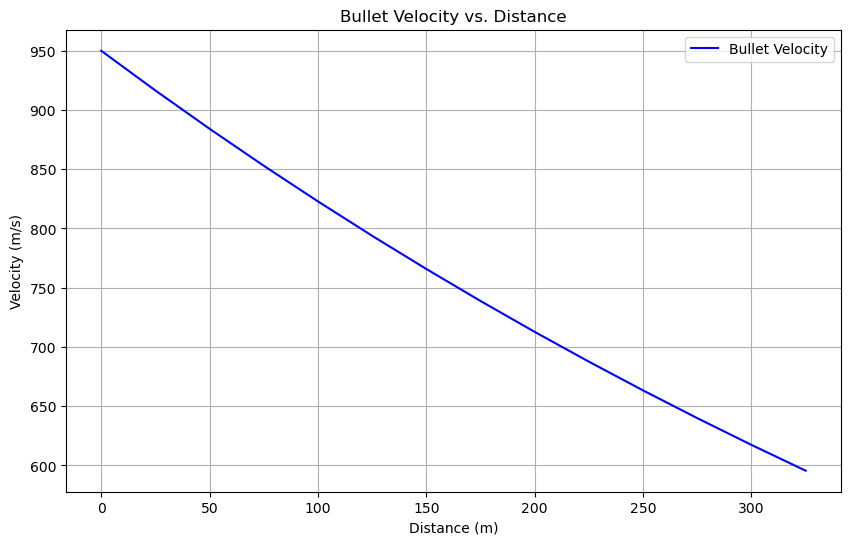

In [36]:
# Plotting the bullet velocity over distance
plt.figure(figsize=(10, 6))
plt.plot(distances, velocities, label='Bullet Velocity', color='blue')
plt.title("Bullet Velocity vs. Distance")
plt.xlabel("Distance (m)")
plt.ylabel("Velocity (m/s)")
plt.grid(True)
plt.legend()
plt.show()

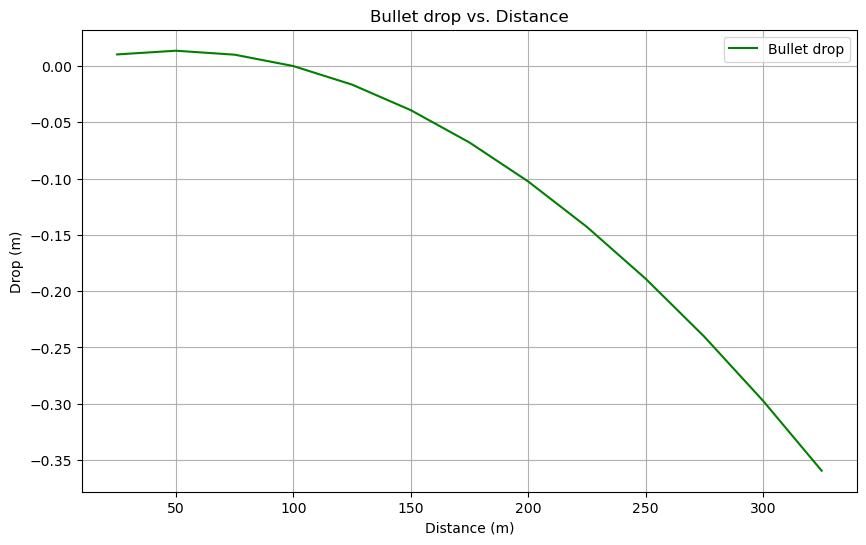

In [37]:
# Plotting the bullet drop over distance
plt.figure(figsize=(10, 6))
plt.plot(distances, pois, label='Bullet drop', color='green')
plt.title("Bullet drop vs. Distance")
plt.xlabel("Distance (m)")
plt.ylabel("Drop (m)")
plt.grid(True)
plt.legend()
plt.show()

In [38]:
3 # Ballistic tables
velocities = np.round(velocities, 0).astype(int)
mrads = np.round(mrads, 2)
clicks = np.round(np.array(list(map(lambda x: x/mrad_per_click, mrads)))).astype(int)
d = {'v (m/s)': velocities, 'drop (m)': pois, 'mrads': mrads, 'clicks': clicks}
df = pd.DataFrame(data=d, index=distances)
df = df.round({'v': 3, 'drop (m)': 2, 'mrads': 2})
display(df)


,v (m/s),drop (m),mrads,clicks
0,950,NaN,0.00,0
25,916,0.01,-0.41,-4
50,884,0.01,-0.27,-3
75,853,0.01,-0.13,-1
100,823,-0.00,0.00,0
125,794,-0.02,0.13,1
150,766,-0.04,0.26,3
175,739,-0.07,0.39,4
200,713,-0.10,0.51,5
225,688,-0.14,0.63,6
